In [169]:
!pip install snntorch

In [170]:
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [171]:
batch_size = 128
data_path='/tmp/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [172]:
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)


train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [173]:
spike_grad = surrogate.fast_sigmoid(slope=5)
beta = 0.9
num_steps = 50

In [174]:
!pip install torchsummary

# Mid model

In [175]:
#net = nn.Sequential(nn.Conv2d(1, 5, 5),
#                    nn.MaxPool2d(2),
#                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    

#                    nn.Conv2d(5, 16, 5),
#                    nn.MaxPool2d(2),
#                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),

#                    nn.Flatten(),
#                    nn.Linear(256, 10),
#                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    
#                    ).to(device)

In [176]:
#from torchsummary import summary
#summary(net, (1, 28, 28)) 

# smallest

In [177]:
net = nn.Sequential(nn.Conv2d(1, 3, 6), #(1, 3, 5) hobe for 3864 params
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    
                    nn.Conv2d(3, 5, 5), #(3, 16, 5)hobe for 3864 params
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),

                    nn.Flatten(),
                    nn.Linear(45, 10),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    
                    ).to(device)

In [178]:
from torchsummary import summary
summary(net, (1, 28, 28)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 23, 23]             111
         MaxPool2d-2            [-1, 3, 11, 11]               0
             Leaky-3            [-1, 3, 11, 11]               0
            Conv2d-4              [-1, 5, 7, 7]             380
         MaxPool2d-5              [-1, 5, 3, 3]               0
             Leaky-6              [-1, 5, 3, 3]               0
           Flatten-7                   [-1, 45]               0
            Linear-8                   [-1, 10]             460
             Leaky-9       [[-1, 10], [-1, 10]]               0
Total params: 951
Trainable params: 951
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.00
Estimated Total Size (MB): 0.03
---------------------------------------------------

In [179]:
data, targets = next(iter(train_loader))

data = data.to(device)

targets = targets.to(device)

for step in range(num_steps):
    spk_out, mem_out = net(data)

In [180]:
spk_out

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<MulBackward0>)

In [181]:
mem_out

tensor([[ 0.2047, -1.0329, -0.2728,  ...,  0.5262,  0.4418, -1.7389],
        [ 0.6000, -1.0019,  0.5202,  ...,  0.9202, -0.0102, -2.1123],
        [ 0.1425, -0.8326,  0.9271,  ...,  0.3126,  0.5888, -1.6970],
        ...,
        [ 0.7599, -1.1320,  1.0859,  ...,  0.7792,  0.2118, -1.4217],
        [ 0.4830, -1.0341,  1.0170,  ...,  1.1574,  0.4813, -1.0536],
        [ 0.7969, -1.2722,  1.0601,  ...,  0.5445,  0.5497, -1.8411]],
       device='cuda:0', grad_fn=<SubBackward0>)

In [182]:
def forward_pass(net, num_steps, data):
  mem_rec = []
  spk_rec = []

  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(num_steps):
      spk_out, mem_out = net(data)
      spk_rec.append(spk_out)
      mem_rec.append(mem_out)

  return torch.stack(spk_rec), torch.stack(mem_rec)

In [183]:
spk_rec, mem_rec = forward_pass(net, num_steps, data)

In [184]:
loss_fn = SF.ce_rate_loss()

In [185]:
loss_val = loss_fn(spk_rec, targets)

print(f"The loss from an untrained network is {loss_val.item():.3f}")

The loss from an untrained network is 2.326


In [186]:
acc = SF.accuracy_rate(spk_rec, targets)

print(f"The accuracy of a single batch using an untrained network is {acc*100:.3f}%")

The accuracy of a single batch using an untrained network is 16.406%


In [187]:
def batch_accuracy(train_loader, net, num_steps):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()

    train_loader = iter(train_loader)
    for data, targets in train_loader:
      data = data.to(device)
      targets = targets.to(device)
      spk_rec, _ = forward_pass(net, num_steps, data)

      acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
      total += spk_rec.size(1)
        
  return acc/total

In [188]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.999))
num_epochs = 5
loss_hist = []
test_acc_hist = []
counter = 0


for epoch in range(num_epochs):
    for data, targets in iter(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, _ = forward_pass(net, num_steps, data)

        # initialize the loss & sum over time
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        #loss_hist.append(loss_val.item())

        # Test set
        if counter % 25 == 0:
          with torch.no_grad():
              net.eval()

              loss_hist.append(loss_val.item())
              # Test set forward pass
              test_acc = batch_accuracy(test_loader, net, num_steps)
              print(f"Iteration {counter}, Test Acc: {test_acc * 100:.2f}%\n")
              test_acc_hist.append(test_acc.item())
              
        counter += 1

Iteration 0, Test Acc: 10.19%

Iteration 25, Test Acc: 62.72%

Iteration 50, Test Acc: 70.85%

Iteration 75, Test Acc: 83.13%

Iteration 100, Test Acc: 84.05%

Iteration 125, Test Acc: 82.42%

Iteration 150, Test Acc: 87.85%

Iteration 175, Test Acc: 88.62%

Iteration 200, Test Acc: 89.89%

Iteration 225, Test Acc: 90.19%

Iteration 250, Test Acc: 89.89%

Iteration 275, Test Acc: 90.04%

Iteration 300, Test Acc: 90.81%

Iteration 325, Test Acc: 90.91%

Iteration 350, Test Acc: 91.39%

Iteration 375, Test Acc: 91.61%

Iteration 400, Test Acc: 91.89%

Iteration 425, Test Acc: 91.90%

Iteration 450, Test Acc: 92.27%

Iteration 475, Test Acc: 92.22%

Iteration 500, Test Acc: 92.20%

Iteration 525, Test Acc: 92.05%

Iteration 550, Test Acc: 91.98%

Iteration 575, Test Acc: 91.41%

Iteration 600, Test Acc: 92.89%

Iteration 625, Test Acc: 92.82%

Iteration 650, Test Acc: 92.79%

Iteration 675, Test Acc: 93.14%

Iteration 700, Test Acc: 93.19%

Iteration 725, Test Acc: 93.25%

Iteration 750, 

In [189]:
test_acc = batch_accuracy(test_loader, net, num_steps)

print(f"The total accuracy on the test set is: {test_acc * 100:.2f}%")

The total accuracy on the test set is: 93.23%


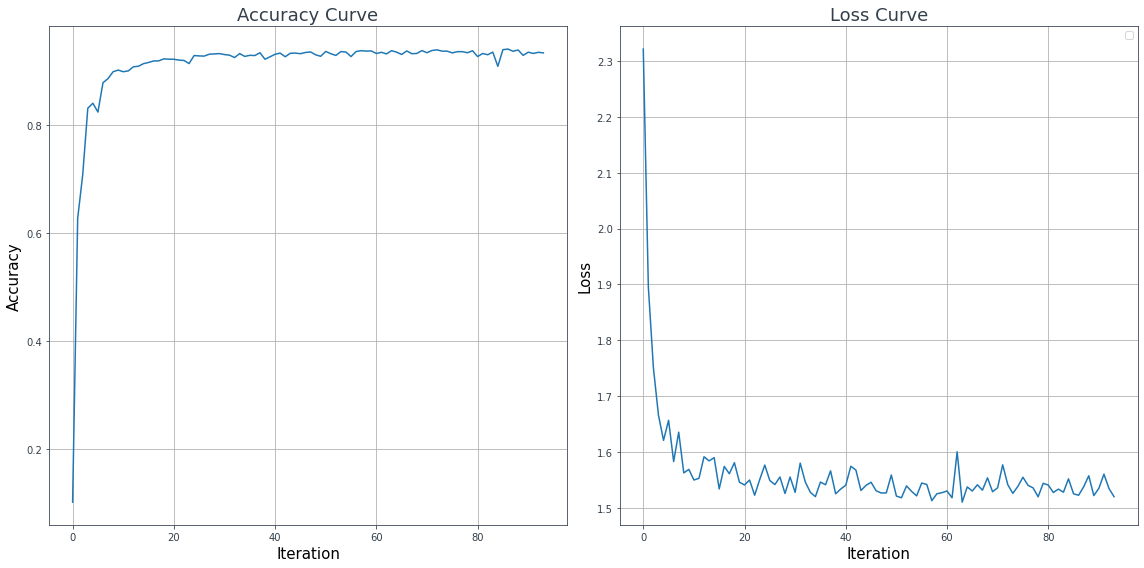

In [263]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot accuracy curve
ax1.plot(test_acc_hist)#, label="Train Accuracy")
ax1.set_title("Accuracy Curve", fontsize = 18)
ax1.set_xlabel("Iteration", fontsize = 15)
ax1.set_ylabel("Accuracy", fontsize = 15)
ax1.grid()

# Plot loss curve
ax2.plot(loss_hist)#, label="Train Loss")  # Assuming loss_hist[0] is train loss
ax2.set_title("Loss Curve", fontsize = 18)
ax2.set_xlabel("Iteration", fontsize = 15)
ax2.set_ylabel("Loss", fontsize = 15)
ax2.legend()
ax2.grid()

# Display the plot
plt.tight_layout()
plt.show()

In [264]:
spk_rec, mem_rec = forward_pass(net, num_steps, data)

The target label is: 3


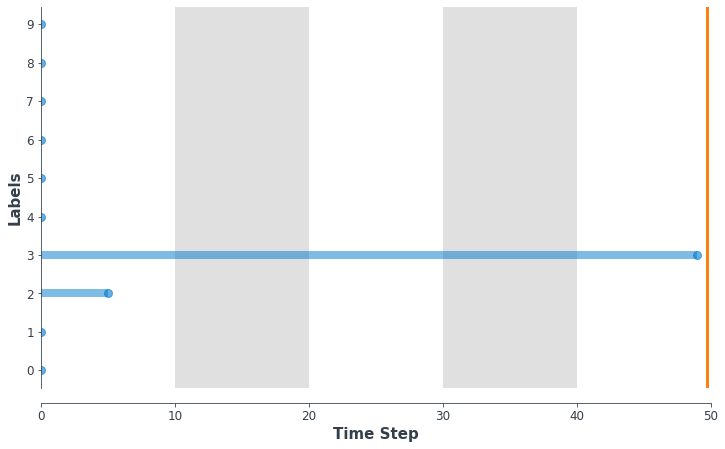

In [265]:
from IPython.display import HTML
idx = 16
fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
print(f"The target label is: {targets[idx]}")
# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'
#  Plot spike count histogram
anim = splt.spike_count(spk_rec[:, idx].detach().cpu(), fig, ax, labels=labels,
                        animate=True, interpolate=4)

HTML(anim.to_html5_video())
# anim.save("spike_bar.mp4")

In [266]:
spk_rec, mem_rec = forward_pass(net, num_steps, data)

In [267]:
spk_rec.size()

torch.Size([50, 128, 10])

In [268]:
mem_rec.size()

torch.Size([50, 128, 10])

In [269]:
spk_rec[:,16,:].size()

torch.Size([50, 10])

In [270]:
spk_rec[:,16,:].min(), spk_rec[:,16,:].max()

(tensor(0., device='cuda:0', grad_fn=<MinBackward1>),
 tensor(1., device='cuda:0', grad_fn=<MaxBackward1>))

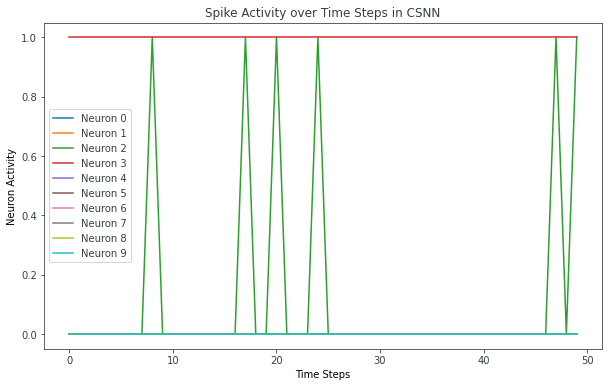

In [274]:
import matplotlib.pyplot as plt
import torch

# Sample data representing spikes or membrane potential values
data_ = spk_rec[:,16,:].to('cpu')  # Replace with your actual data tensor

# Detach the tensor to avoid the error related to requiring gradients
data_ = data_.detach().numpy()  # Detach and convert to NumPy array

# Plot each neuron's activity over time
plt.figure(figsize=(10, 6))
for neuron_idx in range(data_.shape[1]):  # Loop over neurons (10 in this case)
    plt.plot(data_[:, neuron_idx], label=f'Neuron {neuron_idx}')

# Add labels and legend
plt.xlabel('Time Steps')
plt.ylabel('Neuron Activity')
plt.title('Spike Activity over Time Steps in CSNN')
plt.legend()
plt.show()

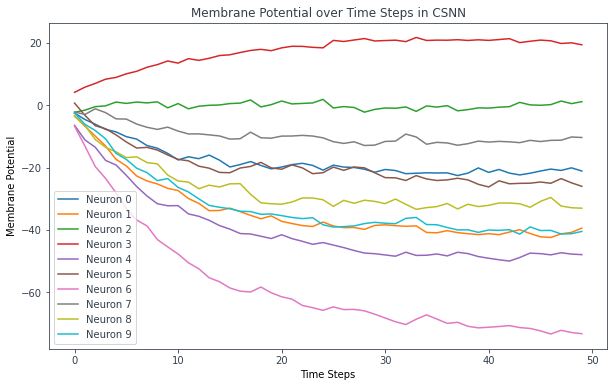

In [278]:
import matplotlib.pyplot as plt
import torch

# Sample data representing spikes or membrane potential values
data_ = mem_rec[:,16,:].to('cpu')  # Replace with your actual data tensor

# Detach the tensor to avoid the error related to requiring gradients
data_ = data_.detach().numpy()  # Detach and convert to NumPy array

# Plot each neuron's activity over time
plt.figure(figsize=(10, 6))
for neuron_idx in range(data_.shape[1]):  # Loop over neurons (10 in this case)
    plt.plot(data_[:, neuron_idx], label=f'Neuron {neuron_idx}')

# Add labels and legend
plt.xlabel('Time Steps')
plt.ylabel('Membrane Potential')
plt.title('Membrane Potential over Time Steps in CSNN')
plt.legend()
plt.show()

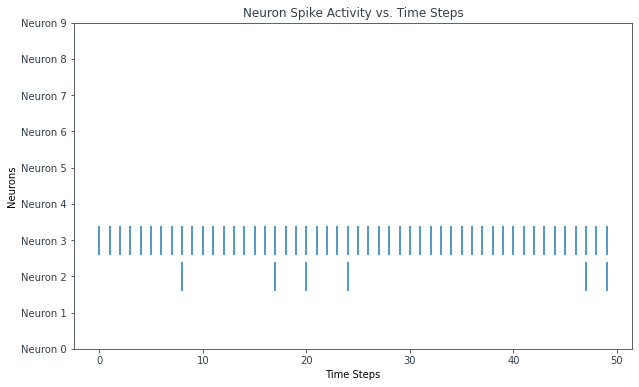

In [279]:
import matplotlib.pyplot as plt
import torch

# Sample data: 50 time steps for 10 neurons
data_ = spk_rec[:,16,:].to('cpu') > 0  # Simulating binary spike data (1 for spike, 0 for no spike)

# Plot the raster plot
plt.figure(figsize=(10, 6))

# Loop through each neuron
for neuron_idx in range(data_.shape[1]):
    # For each neuron, plot a vertical line for each spike time step
    spike_times = torch.nonzero(data_[:, neuron_idx]).squeeze()  # Get the indices where spike occurs
    plt.vlines(spike_times, neuron_idx - 0.4, neuron_idx + 0.4)  # Vertical line at each spike time

# Labeling the plot
plt.xlabel('Time Steps')
plt.ylabel('Neurons')
plt.title('Neuron Spike Activity vs. Time Steps')

# Adjust y-axis to show neuron indices clearly
plt.yticks(range(data_.shape[1]), [f'Neuron {i}' for i in range(data_.shape[1])])

plt.show()

In [280]:
# Extracting one sample (e.g., the first sample) along the second dimension
sample = spk_rec[:, 16, :].to('cpu')  # Selecting the first sample

# Check the shape to confirm
print(sample.size())  # Should output torch.Size([50, 10])

torch.Size([50, 10])


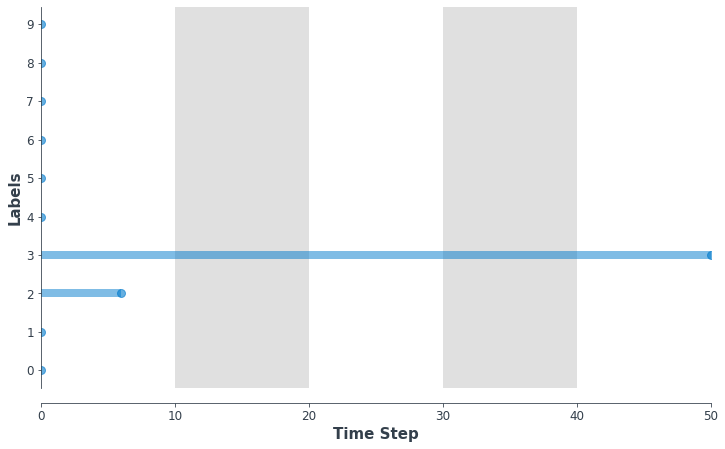

In [281]:
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
ax.set_xlim([0,50])
splt.spike_count(sample.detach(), fig, ax, labels, num_steps=num_steps)
plt.show()

In [282]:
for step in range(num_steps):
    spk_out, mem_out = net(data)

In [283]:
spk_out.size()

torch.Size([128, 10])

In [287]:
targets[16:16+16]

tensor([3, 7, 3, 0, 6, 0, 4, 9, 4, 3, 5, 4, 9, 9, 0, 1], device='cuda:0')

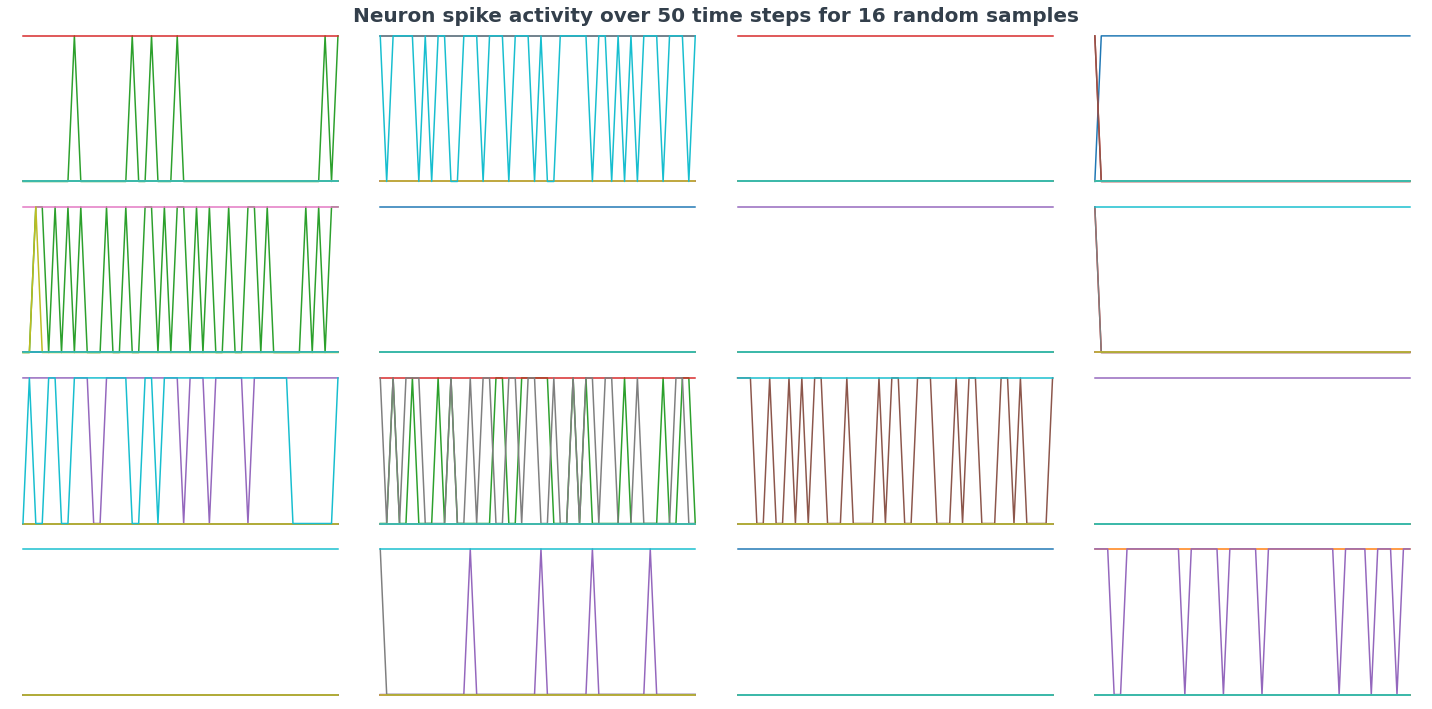

In [304]:
plt.subplots(facecolor='w', figsize=(20, 10))
splt.traces(spk_rec[:, 16:16+16, :], dim=(4,4))
plt.suptitle('Neuron spike activity over 50 time steps for 16 random samples', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust the position of the suptitle
plt.show()

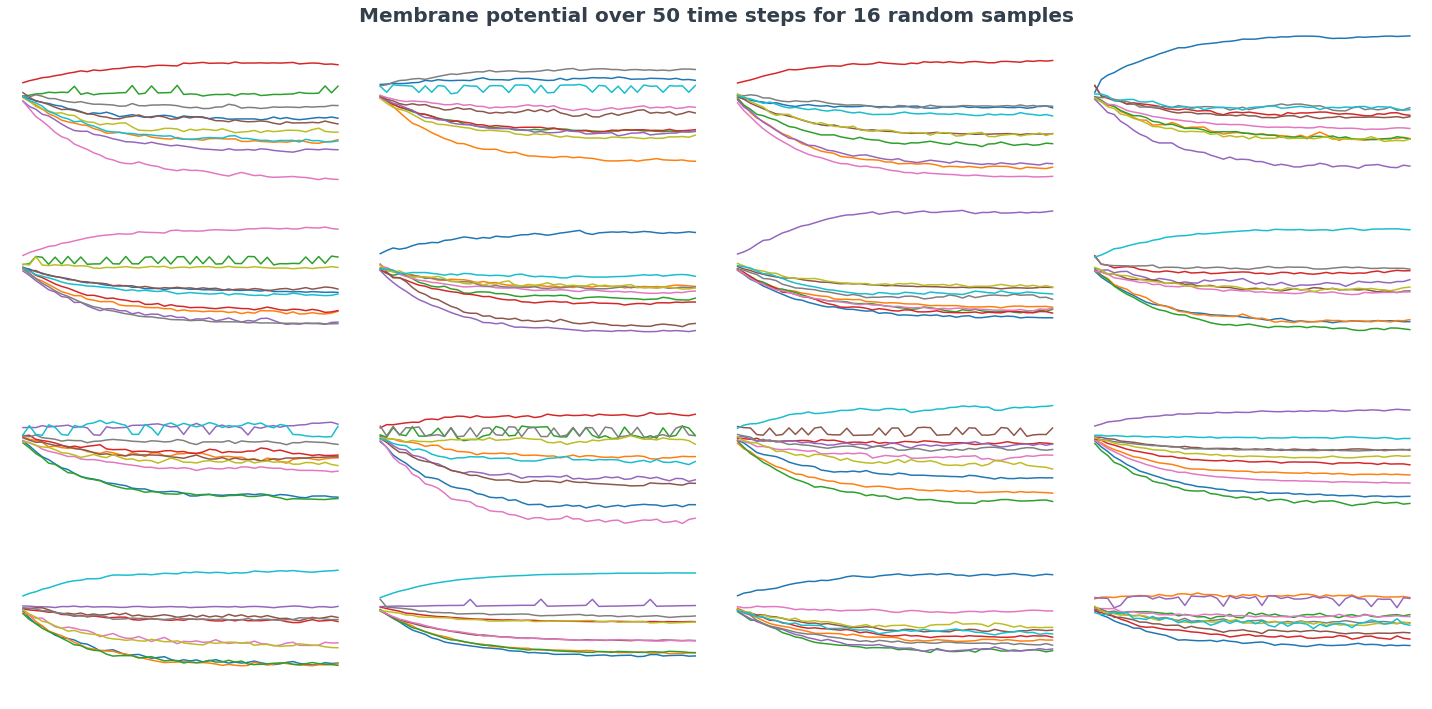

In [308]:
# plot membrane potential traces
plt.subplots(facecolor='w', figsize=(20, 10))
#splt.traces(mem_rec.squeeze(1), dim=(5,4), spk=spk_rec.squeeze(1))
# Example slicing of mem_rec to match the neurons being plotted
splt.traces(mem_rec[:, 16:16+16, :], dim=(4, 4), spk=spk_rec[:, 16:16+16, :])
plt.suptitle('Membrane potential over 50 time steps for 16 random samples', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust the position of the suptitle
fig = plt.gcf()
#fig.set_size_inches(8, 6)